In this notebook, I scrape data from Reddit using PRAWS and grab yfinance data to seek relationships between the volume of posts about XRP on popular crypto subreddits and lagged price movements of XRP. Does reddit really control the markets? We will find out.

In [9]:
import pandas as pd
import os
import yfinance as yf
import praw
import datetime
import matplotlib.pyplot as plt
from dotenv import load_dotenv

load_dotenv()
reddit = praw.Reddit(
    client_id=os.getenv("REDDIT_CLIENT_ID"),
    client_secret=os.getenv("REDDIT_CLIENT_SECRET"),
    username=os.getenv("REDDIT_USERNAME"),
    password=os.getenv("REDDIT_PASSWORD"),
    user_agent=os.getenv("REDDIT_USER_AGENT")
)

Pull last 1000 posts, create list, bucket posts into days where the count is the amount of posts containing the word XRP in the title each day. Analyze volume vs price changes. Normalize and structure volume data.
Iterate using datetime.timedelta

In [10]:
cryptoSubs = reddit.subreddit("CrpytoCurrency+CryptoMarkets+Altcoin+CryptoTechnology+CryptoMoonShots+wallstreetbets")
posts = list(cryptoSubs.new(limit=2500))
firstPost = posts[0]
firstDate =  datetime.datetime.utcfromtimestamp(posts[-1].created_utc).date().strftime("%Y-%m-%d")
lastDate = datetime.datetime.utcfromtimestamp(posts[0].created_utc).date().strftime("%Y-%m-%d")
dailyVolume = {}
currCount = 0
for post in posts:
    text = post.title + " " + post.selftext
    date = datetime.datetime.utcfromtimestamp(post.created_utc).date().strftime("%Y-%m-%d")
    
    if "xrp" in text.lower():
        if date in dailyVolume:
            dailyVolume[date] += 1
        else:
            dailyVolume[date] = 1
            


#Drop the last and most recent days so that we have full days of posts to look at:
if firstDate in dailyVolume:
    dailyVolume.pop(firstDate)
if lastDate in dailyVolume:
    dailyVolume.pop(lastDate)

firstDate = datetime.datetime.utcfromtimestamp(posts[-1].created_utc).date()
lastDate = datetime.datetime.utcfromtimestamp(posts[0].created_utc).date()
curr = firstDate

#incrememnt so we start at the first date present in dailyVolume
datesList = []

curr += datetime.timedelta(days=1)

dailyVolumeList = []
while curr < lastDate:
    key = curr.strftime("%Y-%m-%d")
    if key in dailyVolume:
        dailyVolumeList.append(dailyVolume[key])

    else:
        dailyVolumeList.append(0)
    
    datesList.append(curr)
    curr += datetime.timedelta(days=1)
    


windowLength = len(dailyVolumeList)
print(f"Time window covers {windowLength} days")



Time window covers 67 days


/tmp/ipykernel_25737/143825175.py:4: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  firstDate =  datetime.datetime.utcfromtimestamp(posts[-1].created_utc).date().strftime("%Y-%m-%d")
/tmp/ipykernel_25737/143825175.py:5: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  lastDate = datetime.datetime.utcfromtimestamp(posts[0].created_utc).date().strftime("%Y-%m-%d")
/tmp/ipykernel_25737/143825175.py:10: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, da

Grab price data from YFinance and add in a percent change and price difference field


In [28]:

xrpPrices = yf.Ticker("XRP-USD")
data = xrpPrices.history(interval="1d", start = datetime.datetime.utcfromtimestamp(posts[-2].created_utc).date(), end  = datetime.datetime.utcfromtimestamp(posts[1].created_utc).date())
data["percentChange"] = data["Close"].pct_change()*100
data["percentChange"].dropna().tolist() 
data["dailyMovement"] = data["Close"] - data["Open"]


/tmp/ipykernel_4280/4124188966.py:2: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  data = xrpPrices.history(interval="1d", start = datetime.datetime.utcfromtimestamp(posts[-2].created_utc).date(), end  = datetime.datetime.utcfromtimestamp(posts[1].created_utc).date())


In [34]:
df = pd.DataFrame({
    "Volume": dailyVolumeList,
    "percentChange": data["percentChange"],
    "priceChange": data["dailyMovement"],
    "dates" : datesList
})

for lag in range(1,6):
    df[f'percentChange lag {lag}'] = df['percentChange'].shift(lag)

for lag in range(1,6):
    df[f'priceChange lag {lag}'] = df['priceChange'].shift(lag)


df = df.dropna().reset_index(drop=True)

for lag in range (1,6):
    
    print(f"Pearson correlation for percent change lag {lag} = {df['Volume'].corr(df[f'percentChange lag {lag}'])}")

for lag in range (1,6):
    
    print(f"Pearson correlation for price change lag {lag} = {df['Volume'].corr(df[f'priceChange lag {lag}'])}")

Pearson correlation for percent change lag 1 = -0.04592896928492987
Pearson correlation for percent change lag 2 = 0.29000015406480034
Pearson correlation for percent change lag 3 = 0.22440901523466558
Pearson correlation for percent change lag 4 = 0.22961699494499066
Pearson correlation for percent change lag 5 = 0.21067282091841302
Pearson correlation for price change lag 1 = -0.033013745531312415
Pearson correlation for price change lag 2 = 0.3115163534615721
Pearson correlation for price change lag 3 = 0.21581081609883845
Pearson correlation for price change lag 4 = 0.2179042836352998
Pearson correlation for price change lag 5 = 0.20647335546182685


Visualizations and findings

In [35]:
print(f"Dates length: {len(datesList)}")
print(f"price movement length: {len(df["Volume"])}")
print(f"Volume length: {len(dailyVolumeList)}")

Dates length: 68
price movement length: 62
Volume length: 68


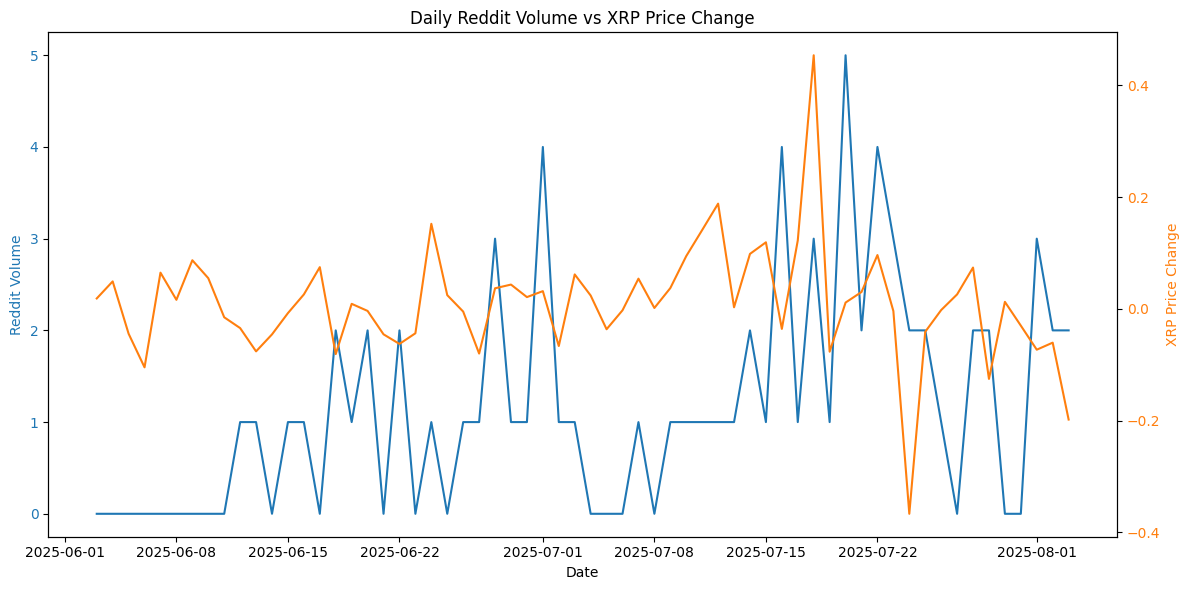

In [36]:
fig, ax1 = plt.subplots(figsize=(12, 6))


# Volume on left y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Reddit Volume', color='tab:blue')
ax1.plot(df["dates"], df["Volume"], color='tab:blue', label='Reddit Volume')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Price change on right y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('XRP Price Change', color='tab:orange')
ax2.plot(df["dates"], df["priceChange"], color='tab:orange', label='XRP Price Change')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Daily Reddit Volume vs XRP Price Change')
fig.tight_layout()
plt.show()

Answer: probably not.